# 模型评估

1. 想要计算混淆矩阵，要先进行test导出推理结果，这里导出的文件由--out指定

In [10]:
# !python ../tools/test.py \
# ../configs/mel/efficientnet-b0_8xb32_isic2018task3.py \
# ../work_dirs/efficientnet-b0_8xb32_isic2018task3/epoch_55.pth \
# --out efficientnet-b0_result.pkl

In [18]:
import mmcv
from mmcls.datasets import build_dataset
from mmcls.core.evaluation import calculate_confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import torch
from torch import Tensor
from sklearn import metrics

1. expose confusion matrix

In [12]:
cfg = mmcv.Config.fromfile("../configs/mel/efficientnet-b0_8xb32_isic2018task3.py")
dataset = build_dataset(cfg.data.test)

pred = mmcv.load("./efficientnet-b0_result.pkl")['class_scores']

pred = torch.from_numpy(pred)
pred_label = torch.argmax(pred, dim=1).flatten()

target = torch.from_numpy(dataset.get_gt_labels())
target_label = target.flatten()
matrix = calculate_confusion_matrix(pred, dataset.get_gt_labels())
matrix # 由此可以计算指标。
# [
#     [TN, FP],
#     [FN, TP],
# ]





tensor([[122,   1],
        [  6,  15]])

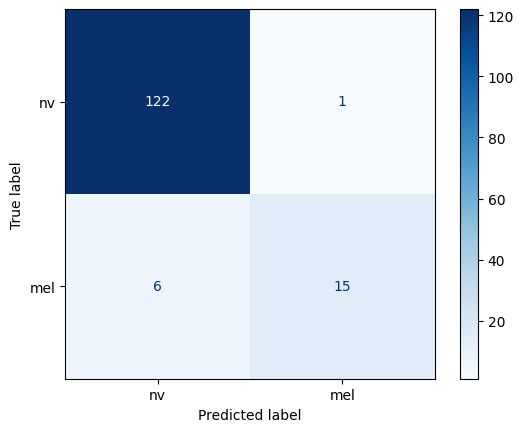

In [13]:
classes = ['nv', 'mel']

# 使用sklearn工具中confusion_matrix方法计算混淆矩阵
confusion_mat = confusion_matrix(target_label, pred_label)

# 使用sklearn工具包中的ConfusionMatrixDisplay可视化混淆矩阵，参考plot_confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)
disp.plot(
    include_values=True,            # 混淆矩阵每个单元格上显示具体数值
    cmap="Blues",                   # 不清楚啥意思，没研究，使用的sklearn中的默认值
    ax=None,                        # 同上
    xticks_rotation="horizontal",   # 同上
    values_format="d"               # 显示的数值格式
)
plt.show()

2. get metrics: acc, precision, recall, f1_score, f2_score

In [28]:
# 总体acc
acc = metrics.accuracy_score(target_label, pred_label)
# positive的precision recall f1 f2
recall = metrics.recall_score(target_label, pred_label, pos_label = 1)
precision = metrics.precision_score(target_label, pred_label, pos_label = 1)
f1_score = metrics.f1_score(target_label, pred_label, pos_label = 1)
f2_score = metrics.fbeta_score(target_label, pred_label, beta=2, pos_label = 1)
metric = {
    'acc': round(acc, 4),
    'precision': round(precision, 4),
    'recall': round(recall, 4),
    'f1_score' : round(f1_score, 4),
    'f2_score': round(f2_score, 4)
}

metric

{'acc': 0.9514,
 'precision': 0.9375,
 'recall': 0.7143,
 'f1_score': 0.8108,
 'f2_score': 0.75}

3. get auc and roc curve

fpr 真正率 = 灵敏度 = recall

假正率（FPR） = 1- 特异度 = FP/(FP+TN)

如何根据roc曲线选择高recall模型：https://blog.csdn.net/m0_55097528/article/details/125122744

In [29]:
fpr, tpr, threshold = metrics.roc_curve(target_label, pred_label, pos_label = 1)
auc = metrics.auc(fpr, tpr)
auc



0.8530778164924506

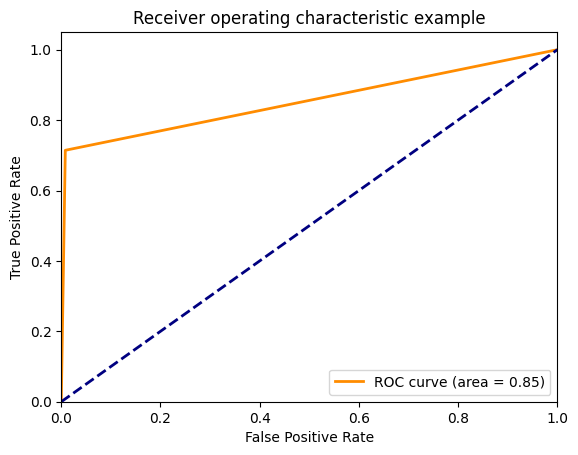

In [30]:
# 画出roc 曲线

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
